<a href="https://colab.research.google.com/github/c-susan/datasci_6_anova/blob/main/python_anova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading in Packages

In [2]:
!pip install ucimlrepo

In [3]:
## bringing in data
from ucimlrepo import fetch_ucirepo

##bring in packages for dataframe + stats
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

## for visualization
import matplotlib.pyplot as plt

# **1. Data Preparation**

> Creating a subset of the data with only the variables of interest and checking that types are appropriate given the variable.

**Question**: Does race and gender have a combined influence on the amount of days spent in the hospital (time_in_hospital)?

**DV**: time_in_hospital

**IV1**: race

**IV2**: gender

**H0 (Null Hypothesis)**: There is no significant combined influence of race and gender on the amount of days spent in the hospital.

**H1 (Alternative Hypothesis)**: There is a significant combined influence of race and gender on the amount of days spent in the hospital.

In [4]:
# fetching dataset
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)

# data (as pandas dataframes)
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets

/usr/local/lib/python3.10/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


In [5]:
df = pd.DataFrame(X)
df.columns = df.columns.str.replace('-','_', regex=True)
df.sample(5)

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,examide,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed
34336,NaN,Male,[50-60),NaN,2,1,1,1,BC,Family/GeneralPractice,...,No,No,Steady,No,No,No,No,No,No,Yes
36662,Hispanic,Male,[30-40),NaN,2,1,1,7,NaN,Family/GeneralPractice,...,No,No,Steady,No,No,No,No,No,No,Yes
38945,Caucasian,Female,[80-90),NaN,6,3,17,2,NaN,Family/GeneralPractice,...,No,No,No,No,No,No,No,No,No,Yes
5889,AfricanAmerican,Female,[60-70),NaN,1,1,7,3,NaN,NaN,...,No,No,No,No,No,No,No,No,Ch,Yes
15771,Caucasian,Male,[40-50),NaN,1,1,7,3,NaN,NaN,...,No,No,Steady,No,No,No,No,No,No,Yes


In [6]:
df['gender'].value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [7]:
df = df[(df['gender'].isin(['Female', 'Male']))]

In [8]:
df = df[['race', 'gender', 'time_in_hospital']]
df.sample(5)

,race,gender,time_in_hospital
65425,Caucasian,Male,1
74444,NaN,Male,1
95461,Caucasian,Female,3
7179,AfricanAmerican,Female,5
11688,AfricanAmerican,Female,8


# **2. Assumption Checks**

> Checking for normality and homogeneity of variance.



In [9]:
print('Main DV:', stats.shapiro(df['time_in_hospital']))

Main DV: ShapiroResult(statistic=0.8869178891181946, pvalue=0.0)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


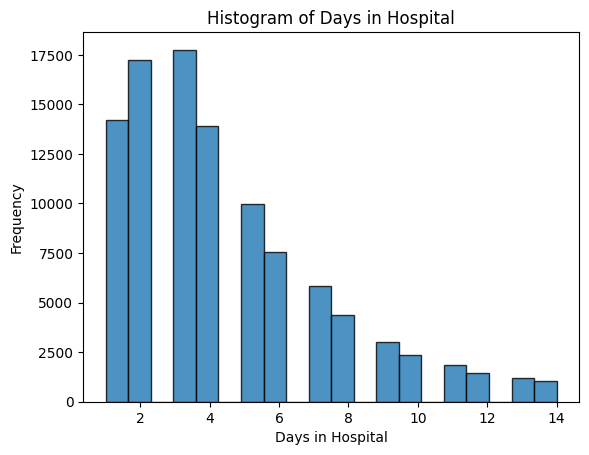

In [10]:
plt.hist(df['time_in_hospital'], bins=20, edgecolor='k', alpha=0.8)
plt.title('Histogram of Days in Hospital')
plt.xlabel('Days in Hospital')
plt.ylabel('Frequency')
plt.show()

In [11]:
## Checking for normality
groups = df.groupby(['race', 'gender'])

for (race_status, gender_status), group_df in groups:
  if len(group_df['time_in_hospital']):
      _, p_value = stats.shapiro(group_df['time_in_hospital'])

      print(f"Group ({race_status}, {gender_status}):")
      print(f"P-value from Shapiro-Wilk Test: {p_value}\n")

Group (AfricanAmerican, Female):
P-value from Shapiro-Wilk Test: 0.0

Group (AfricanAmerican, Male):
P-value from Shapiro-Wilk Test: 0.0

Group (Asian, Female):
P-value from Shapiro-Wilk Test: 9.520779367313894e-17

Group (Asian, Male):
P-value from Shapiro-Wilk Test: 4.219604476332644e-16

Group (Caucasian, Female):
P-value from Shapiro-Wilk Test: 0.0

Group (Caucasian, Male):
P-value from Shapiro-Wilk Test: 0.0

Group (Hispanic, Female):
P-value from Shapiro-Wilk Test: 9.368428169951816e-30

Group (Hispanic, Male):
P-value from Shapiro-Wilk Test: 5.67417287622373e-27

Group (Other, Female):
P-value from Shapiro-Wilk Test: 2.508905647524163e-24

Group (Other, Male):
P-value from Shapiro-Wilk Test: 1.5322922575434318e-23



/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [12]:
## Checking for homogeneity of variance
stats.levene(
    df['time_in_hospital'][df['race'] == 'AfricanAmerican'][df['gender'] == 'Female'],
    df['time_in_hospital'][df['race'] == 'AfricanAmerican'][df['gender'] == 'Male'],
    df['time_in_hospital'][df['race'] == 'Asian'][df['gender'] == 'Female'],
    df['time_in_hospital'][df['race'] == 'Asian'][df['gender'] == 'Male'],
    df['time_in_hospital'][df['race'] == 'Caucasian'][df['gender'] == 'Female'],
    df['time_in_hospital'][df['race'] == 'Caucasian'][df['gender'] == 'Male'],
    df['time_in_hospital'][df['race'] == 'Hispanic'][df['gender'] == 'Female'],
    df['time_in_hospital'][df['race'] == 'Hispanic'][df['gender'] == 'Male'],
    df['time_in_hospital'][df['race'] == 'Other'][df['gender'] == 'Female'],
    df['time_in_hospital'][df['race'] == 'Other'][df['gender'] == 'Male'],
)

LeveneResult(statistic=4.212648053226347, pvalue=1.8106820990342793e-05)

## **Interpretations**

**Shapiro-Wilk Test**
+ The Shapiro-Wilk test for 'time_in_hospital' shows a p-value of 0.0, which is less than the significance level of 0.05. This means that the 'time_in_hospital' is not equally distributed. In addition, as seen in the histogram, 'Histogram of Days in Hospital', the graph has a right skew with more people having spent 1-4 days in the hospital compared to 10-14 days.
+ The Shapiro-Wilk test for the independent variables, race and gender, shows all p-values less than 0.05, with 4 combinations having p-values of zero. This means that the null hypothesis is rejected and that race and gender has a significant combined infuence on the amount of days spent in the hospital.

*It should be noted that the shapiro test may not be accurate as the dataset contains a sample size more than 5000 (N > 5000), as noted in the warnings shown below each shapiro test result.*

**Levene**
+ The Levene tests show a p-value of 1.8106820990342793e-05, which is less than the significance level of 0.05. This means that the homogeneity of variance is unequal.

# **3. ANOVA Analysis**


> Performing 2-way anova analysis of the IV and DV variables.



In [13]:
model = ols('time_in_hospital ~ C(race) * C(gender)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                          sum_sq       df          F        PR(>F)
C(race)               541.291144      4.0  15.189971  2.025732e-12
C(gender)             707.448149      1.0  79.410993  5.127034e-19
C(race):C(gender)      94.442648      4.0   2.650295  3.143751e-02
Residual           886254.590879  99482.0        NaN           NaN


## **Interpretations**

+ Race has a significant influence on the days spent in the hospital (p-value is less than 0.05).
+ Gender has a significant influence on the days spent in the hospital (p-value is less than 0.05).
+ Race and gender has a significant combined influence on the days spent in the hospital (p-value is less than 0.05).

# **Challenges Faced**

When conducting the anova analysis, the anova results showed NaN's in the 'C(race):C(gender)' row. Looking at this, I went back to perform value counts of each of the variables. The value counts for the gender column showed a value of 'Unkown/Invalid' with a frequency of 3. I have to remove the Unkown/Invalid' in order to perform the anova analysis.